In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from io import StringIO
import warnings
from sklearn.ensemble import IsolationForest
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack


In [22]:
def run_pipeline_for_metrics():
    """
    Main pipeline function to process each metric's data separately.
    """
    # Define a dictionary of your data files. Update the paths as needed.
    data_files = {
        'metric_1': r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\Codes\metric_1_data.csv",
        'metric_2': r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\Codes\metric_2_data.csv",
        'metric_3': r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\Codes\metric_3_data.csv"
    }

    # Pre-define the categorical features to ensure consistent columns across all files
    categorical_features = ['datacenter', 'instance']
    numerical_features = ['value']

    for metric_name, file_path in data_files.items():
        print(f"===========================================================")
        print(f"|  Processing Data for: {metric_name.upper()}  |")
        print(f"===========================================================")

        try:
            # Load the CSV using ';' as the separator
            df = pd.read_csv(file_path, sep=';')
            print("Data loaded successfully.")

            # --- Data Cleaning Step ---
            # Replace inf/-inf with NaN and then drop rows with NaN values.
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.dropna(subset=['value'], inplace=True)
            
            if df.empty:
                print("Warning: The dataset is empty after cleaning. Skipping this file.")
                print("-" * 35)
                continue

            # --- Preprocessing Step ---
            # Check if all required columns exist
            required_columns = numerical_features + categorical_features
            if not all(col in df.columns for col in required_columns):
                missing_cols = [col for col in required_columns if col not in df.columns]
                raise KeyError(f"Required columns not found in the file: {missing_cols}. Please check your CSV file headers.")

            # Use a sparse output for OneHotEncoder to save memory
            encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
            scaler = StandardScaler()
            
            # Scale numerical data first
            df_scaled_array = scaler.fit_transform(df[numerical_features])
            
            # One-hot encode categorical data into a sparse matrix
            df_encoded_sparse = encoder.fit_transform(df[categorical_features])
            
            # Combine the scaled numerical data (as a dense array) with the sparse categorical data
            # This is a critical step for memory efficiency
            
            X_sparse = hstack([df_scaled_array, df_encoded_sparse])
            
            print("\n--- Preprocessing Complete ---")
            print(f"Final feature matrix shape: {X_sparse.shape}")
            print(f"Data type: {type(X_sparse)}")
            print("-" * 35)

            # --- K-Means Clustering Step ---
            n_clusters = 2  # You can choose the optimal number of clusters
            print("\n--- K-Means Clustering ---")
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
            df.reset_index(drop=True, inplace=True)
            df['cluster_label'] = kmeans.fit_predict(X_sparse)
            
            print(f"K-Means clustering with {n_clusters} clusters completed.")
            print("\nFirst 5 data points with their assigned cluster labels:")
            print(df[['value', 'datacenter', 'instance', 'cluster_label']].head().to_string())
            
            print("\nTo find the optimal number of clusters, you would typically use the elbow method.")
            
            print("-" * 35)

            # --- PCA Step ---
            n_components = 2
            print("\n--- Principal Component Analysis (PCA) ---")
            # PCA can work with sparse matrices
            pca = PCA(n_components=n_components)
            principal_components = pca.fit_transform(X_sparse.toarray() if isinstance(X_sparse, np.ndarray) else X_sparse)
            
            pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
            pca_df['cluster_label'] = df['cluster_label']
            
            print(f"Data reduced to {n_components} principal components.")
            print("\nExplained variance ratio for each component:")
            for i, explained_variance in enumerate(pca.explained_variance_ratio_):
                print(f"  PC{i+1}: {explained_variance:.4f}")
            print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

            # --- Plotting Results ---
            print("\n--- Generating Plots ---")
            
            # Plot PCA Results with K-Means Clusters
            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster_label'], cmap='viridis', alpha=0.6)
            plt.title(f"PCA with K-Means Clusters for {metric_name}")
            plt.xlabel("Principal Component 1")
            plt.ylabel("Principal Component 2")
            plt.legend(*scatter.legend_elements(), title="Clusters")
            plt.grid(True)
            plt.show()
            

            # Plot Explained Variance Ratio
            plt.figure(figsize=(10, 6))
            plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
            plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), c='red', marker='o')
            plt.title(f"Explained Variance for {metric_name}")
            plt.xlabel("Principal Component")
            plt.ylabel("Explained Variance Ratio")
            plt.grid(True)
            plt.show()
            
            print("-" * 35)

        except FileNotFoundError:
            print(f"Error: The file '{file_path}' was not found.")
            print("Please check the file path and try again.")
            print("-" * 35)
        except Exception as e:
            print(f"An unexpected error occurred while processing {metric_name}: {e}")
            print("-" * 35)

|  Processing Data for: METRIC_1  |
Data loaded successfully.

--- Preprocessing Complete ---
Final feature matrix shape: (28352782, 62)
Data type: <class 'scipy.sparse._coo.coo_matrix'>
-----------------------------------

--- K-Means Clustering ---
K-Means clustering with 2 clusters completed.

First 5 data points with their assigned cluster labels:
      value datacenter    instance  cluster_label
0  0.968522    region1   instance1              0
1  0.962968    region4  instance10              0
2  0.971853    region5  instance11              0
3  0.968439    region5  instance12              0
4  0.978840    region6  instance13              1

To find the optimal number of clusters, you would typically use the elbow method.
-----------------------------------

--- Principal Component Analysis (PCA) ---
Data reduced to 2 principal components.

Explained variance ratio for each component:
  PC1: 0.3515
  PC2: 0.0693
Total explained variance: 0.4207

--- Generating Plots ---


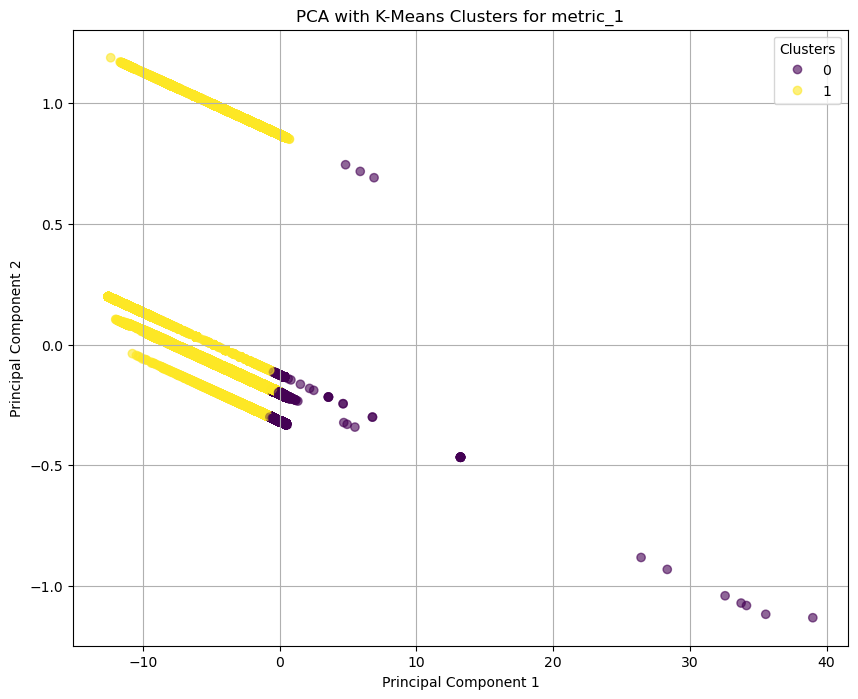

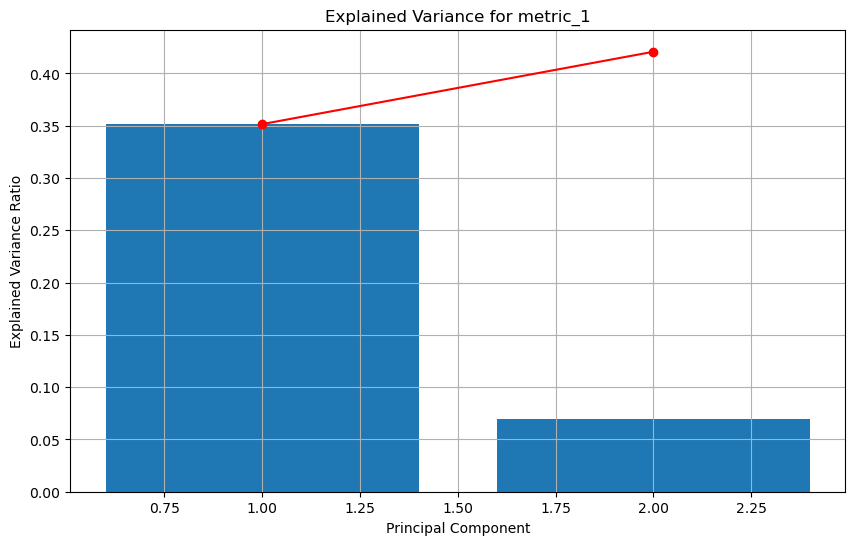

-----------------------------------
|  Processing Data for: METRIC_2  |
Data loaded successfully.

--- Preprocessing Complete ---
Final feature matrix shape: (28352261, 62)
Data type: <class 'scipy.sparse._coo.coo_matrix'>
-----------------------------------

--- K-Means Clustering ---
K-Means clustering with 2 clusters completed.

First 5 data points with their assigned cluster labels:
      value datacenter    instance  cluster_label
0  0.995121    region1   instance1              0
1  0.620534    region4  instance10              1
2  0.581100    region5  instance11              1
3  0.613908    region5  instance12              1
4  0.655141    region6  instance13              1

To find the optimal number of clusters, you would typically use the elbow method.
-----------------------------------

--- Principal Component Analysis (PCA) ---
Data reduced to 2 principal components.

Explained variance ratio for each component:
  PC1: 0.3796
  PC2: 0.0624
Total explained variance: 0.4420


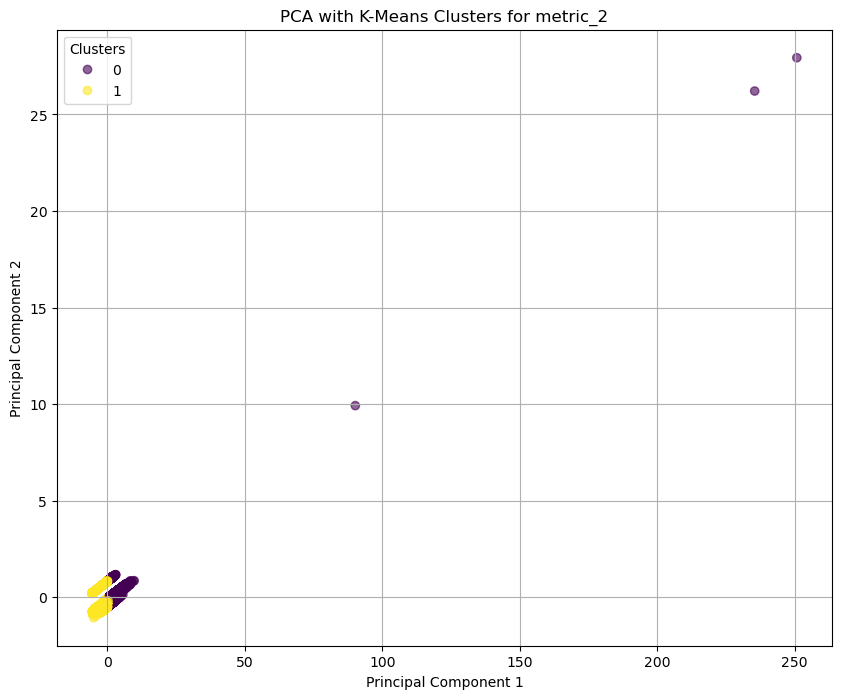

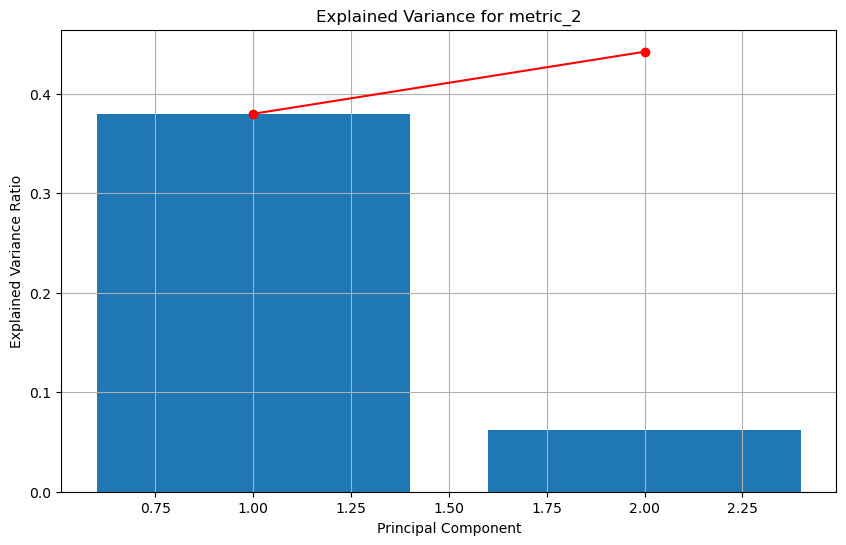

-----------------------------------
|  Processing Data for: METRIC_3  |
Data loaded successfully.

--- Preprocessing Complete ---
Final feature matrix shape: (28727444, 62)
Data type: <class 'scipy.sparse._coo.coo_matrix'>
-----------------------------------

--- K-Means Clustering ---
K-Means clustering with 2 clusters completed.

First 5 data points with their assigned cluster labels:
   value datacenter    instance  cluster_label
0    0.0    region1   instance1              0
1    0.0    region4  instance10              0
2    0.0    region5  instance11              0
3    0.0    region5  instance12              0
4    0.0    region6  instance13              0

To find the optimal number of clusters, you would typically use the elbow method.
-----------------------------------

--- Principal Component Analysis (PCA) ---
Data reduced to 2 principal components.

Explained variance ratio for each component:
  PC1: 0.3476
  PC2: 0.0672
Total explained variance: 0.4149

--- Generating Pl

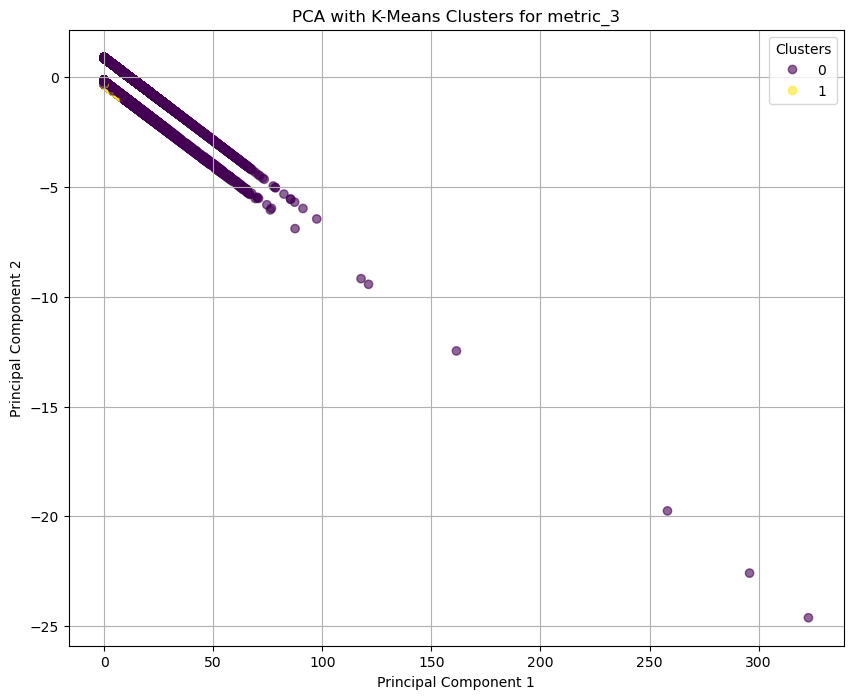

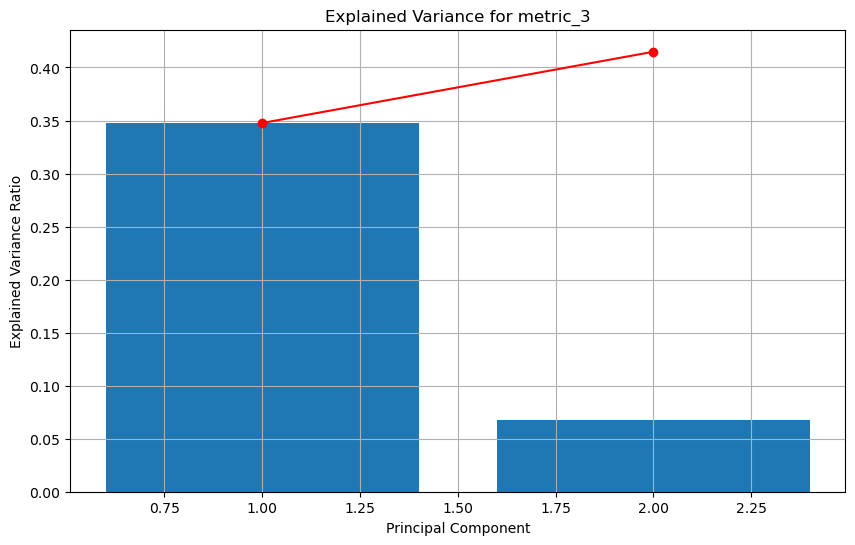

-----------------------------------


In [23]:
if __name__ == "__main__":
    run_pipeline_for_metrics()

In [ ]:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    import warnings
    import joblib

In [19]:
warnings.filterwarnings("ignore", category=UserWarning)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class AutoencoderClassifier(nn.Module):
    """
    Autoencoder with a classification head for semi-supervised learning.
    """
    def __init__(self, input_dim):
        super(AutoencoderClassifier, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

        # Classification head for binary classification
        self.classification_head = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, mode='reconstruction'):
        encoded = self.encoder(x)
        if mode == 'reconstruction':
            return self.decoder(encoded)
        elif mode == 'classification':
            return self.classification_head(encoded)
        else:
            raise ValueError("Invalid mode. Use 'reconstruction' or 'classification'.")

def run_autoencoder_pipeline(X_sparse, df, metric_name, model_dir):
    """
    Runs the autoencoder pipeline, trains the model, and saves its weights.
    """
    print("\n--- Running Autoencoder for Anomaly Detection (PyTorch) ---")
    
    # Convert to CSR format for efficient row-based slicing
    X_csr = X_sparse.tocsr()
    
    # Sample a smaller subset for PCA and autoencoder training
    sample_size = 100000
    if X_csr.shape[0] > sample_size:
        indices = np.random.choice(X_csr.shape[0], sample_size, replace=False)
        X_sample = X_csr[indices, :]
    else:
        X_sample = X_csr
        
    # PCA on a dense sample
    X_dense_sample = X_sample.toarray()
    n_components = 60
    pca = PCA(n_components=n_components)
    X_pca_sample = pca.fit_transform(X_dense_sample)
    

    # --- Save the PCA model ---
    joblib.dump(pca, os.path.join(model_dir, f"{metric_name}_pca.joblib"))
    print("--- PCA model saved successfully ---")
    # --- End of saving ---


    print(f"Data reduced to {n_components} principal components for training.")
    print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")
    
    input_dim = X_pca_sample.shape[1]
    model = AutoencoderClassifier(input_dim).to(device)
    
    # --- Phase 1: Unsupervised Pre-training ---
    print("Phase 1: Unsupervised pre-training...")
    optimizer_rec = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn_rec = nn.MSELoss()
    
    X_tensor_sample = torch.tensor(X_pca_sample, dtype=torch.float32).to(device)
    dataset_rec = TensorDataset(X_tensor_sample, X_tensor_sample)
    dataloader_rec = DataLoader(dataset_rec, batch_size=256, shuffle=True)
    
    model.train()
    for epoch in range(10):
        for batch_data, _ in dataloader_rec:
            reconstructed = model(batch_data, mode='reconstruction')
            loss = loss_fn_rec(reconstructed, batch_data)
            optimizer_rec.zero_grad()
            loss.backward()
            optimizer_rec.step()
    print("Pre-training complete.")

    # --- Phase 2: Supervised Fine-tuning (Dummy Labels) ---
    print("Phase 2: Supervised fine-tuning...")
    # Generate dummy labels for the classification head based on reconstruction error
    model.eval()
    with torch.no_grad():
        reconstructed = model(X_tensor_sample, mode='reconstruction')
        mse = torch.mean(torch.pow(X_tensor_sample - reconstructed, 2), dim=1)
        threshold = torch.quantile(mse, 0.99)
        labels_tensor = (mse > threshold).float().to(device)
    
    # Freeze autoencoder weights
    for param in model.encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = False

    optimizer_cls = torch.optim.Adam(model.classification_head.parameters(), lr=1e-3)
    loss_fn_cls = nn.BCELoss()
    
    dataset_cls = TensorDataset(X_tensor_sample, labels_tensor.unsqueeze(1))
    dataloader_cls = DataLoader(dataset_cls, batch_size=256, shuffle=True)

    model.train()
    for epoch in range(10):
        for batch_data, batch_labels in dataloader_cls:
            logits = model(batch_data, mode='classification')
            loss = loss_fn_cls(logits, batch_labels)
            optimizer_cls.zero_grad()
            loss.backward()
            optimizer_cls.step()
    print("Fine-tuning complete.")
    
    # --- Prediction on Full Dataset (Chunked to avoid MemoryError) ---
    def data_generator_predict(data, batch_size):
        for i in range(0, data.shape[0], batch_size):
            yield data[i:i + batch_size, :]

    batch_size_predict = 10000
    all_predictions = []
    
    model.eval()
    with torch.no_grad():
        for batch_sparse in data_generator_predict(X_csr, batch_size_predict):
            batch_dense = batch_sparse.toarray()
            transformed_batch = pca.transform(batch_dense)
            tensor_batch = torch.tensor(transformed_batch, dtype=torch.float32).to(device)
            
            predictions = model(tensor_batch, mode='classification').cpu().numpy()
            all_predictions.append(predictions)
    
    all_predictions = np.vstack(all_predictions)
    
    df['anomaly_class_head'] = (all_predictions > 0.5).astype(int)
    df['anomaly_class_head'] = df['anomaly_class_head'].map({0: -1, 1: 1})
    
    num_anomalies_classifier = len(df[df['anomaly_class_head'] == -1])
    print(f"Classifier head detected {num_anomalies_classifier} anomalies.")
    
    # Save the trained PyTorch model
    model_path = f"{model_dir}/{metric_name}_autoencoder.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Autoencoder model saved to {model_path}")
    
    # --- Plotting Classification Results (on a sample) ---
    print("\n--- Generating Plots for Classification Head Anomaly Detection ---")
    
    plot_sample_size = 100000
    if X_csr.shape[0] > plot_sample_size:
        plot_indices = np.random.choice(X_csr.shape[0], plot_sample_size, replace=False)
        X_plot_sample = X_csr[plot_indices, :].toarray()
        anomaly_labels = df.loc[plot_indices, 'anomaly_class_head']
    else:
        X_plot_sample = X_csr.toarray()
        anomaly_labels = df['anomaly_class_head']
    
    pca_2d = PCA(n_components=2)
    principal_components_2d = pca_2d.fit_transform(pca.transform(X_plot_sample))
    
    pca_df = pd.DataFrame(data=principal_components_2d, columns=['PC1', 'PC2'])
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=anomaly_labels, cmap='coolwarm', alpha=0.6)
    plt.title(f"Classification Head Anomaly Detection for {metric_name}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Anomaly'], title="Status")
    plt.show()

    print("-" * 35)

def run_isolation_forest_pipeline(X_sparse, df, metric_name, model_dir):
    """
    Runs the Isolation Forest pipeline, trains the model, and saves it.
    """
    print("\n--- Running Isolation Forest for Anomaly Detection ---")
    # The 'contamination' parameter is the proportion of outliers in the dataset.
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    
    # Apply the model directly on the sparse matrix
    df['anomaly_iso_forest'] = iso_forest.fit_predict(X_sparse)
    
    num_anomalies_iso = len(df[df['anomaly_iso_forest'] == -1])
    print(f"Isolation Forest detected {num_anomalies_iso} anomalies.")
    
    # Save the Isolation Forest model
    model_path = f"{model_dir}/{metric_name}_isolation_forest.joblib"
    joblib.dump(iso_forest, model_path)
    print(f"Isolation Forest model saved to {model_path}")

    # --- Plotting Isolation Forest Results (on a sample) ---
    print("\n--- Generating Plots for Isolation Forest Anomaly Detection ---")
    
    X_csr = X_sparse.tocsr()
    plot_sample_size = 100000
    if X_csr.shape[0] > plot_sample_size:
        plot_indices = np.random.choice(X_csr.shape[0], plot_sample_size, replace=False)
        X_plot_sample = X_csr[plot_indices, :].toarray()
        anomaly_labels = df.loc[plot_indices, 'anomaly_iso_forest']
    else:
        X_plot_sample = X_csr.toarray()
        anomaly_labels = df['anomaly_iso_forest']
    
    pca_2d = PCA(n_components=2)
    principal_components_2d = pca_2d.fit_transform(X_plot_sample)
    
    pca_df = pd.DataFrame(data=principal_components_2d, columns=['PC1', 'PC2'])
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=anomaly_labels, cmap='coolwarm', alpha=0.6)
    plt.title(f"Isolation Forest Anomaly Detection for {metric_name}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.legend(handles=scatter.legend_elements()[0], labels=['Anomaly', 'Normal'], title="Status")
    plt.show()
    
    print("-" * 35)

def run_pipeline_for_metrics():
    """
    Main pipeline function to process each metric's data separately.
    """
    data_files = {
        'metric_1': r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\Codes\metric_1_data.csv",
        'metric_2': r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\Codes\metric_2_data.csv",
        'metric_3': r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\Codes\metric_3_data.csv"
    }

    categorical_features = ['datacenter', 'instance']
    numerical_features = ['value']

    # Directory to save models
    model_dir = "trained_models"
    import os
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    for metric_name, file_path in data_files.items():
        print(f"===========================================================")
        print(f"|  Processing Data for: {metric_name.upper()}  |")
        print(f"===========================================================")

        try:
            df = pd.read_csv(file_path, sep=';')
            print("Data loaded successfully.")
            
            if df.empty:
                print("Warning: The dataset is empty after loading. Skipping this file.")
                print("-" * 35)
                continue
            
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.dropna(subset=['value'], inplace=True)
            
            if df.empty:
                print("Warning: The dataset is empty after cleaning. Skipping this file.")
                print("-" * 35)
                continue

            required_columns = numerical_features + categorical_features
            if not all(col in df.columns for col in required_columns):
                missing_cols = [col for col in required_columns if col not in df.columns]
                raise KeyError(f"Required columns not found: {missing_cols}")

            encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
            scaler = StandardScaler()
            
            df_scaled_array = scaler.fit_transform(df[numerical_features])
            df_encoded_sparse = encoder.fit_transform(df[categorical_features])



            # --- Save the preprocessing objects ---
            joblib.dump(scaler, os.path.join(model_dir, f"{metric_name}_scaler.joblib"))
            joblib.dump(encoder, os.path.join(model_dir, f"{metric_name}_encoder.joblib"))
            print("\n--- Scaler and Encoder saved successfully ---")
            # --- End of saving ---

            X_sparse = hstack([df_scaled_array, df_encoded_sparse])
            
            print("\n--- Preprocessing Complete ---")
            print(f"Final feature matrix shape: {X_sparse.shape}")
            print(f"Data type: {type(X_sparse)}")
            print("-" * 35)
            
            # Run and save the Isolation Forest model
            run_isolation_forest_pipeline(X_sparse, df.copy(), metric_name, model_dir)
            
            # Run and save the Autoencoder model
            run_autoencoder_pipeline(X_sparse, df.copy(), metric_name, model_dir)

        except FileNotFoundError:
            print(f"Error: The file '{file_path}' was not found.")
            print("Please check the file path and try again.")
            print("-" * 35)
        except Exception as e:
            print(f"An unexpected error occurred while processing {metric_name}: {e}")
            print("-" * 35)


Using device: cuda


|  Processing Data for: METRIC_1  |
Data loaded successfully.

--- Scaler and Encoder saved successfully ---

--- Preprocessing Complete ---
Final feature matrix shape: (28352782, 62)
Data type: <class 'scipy.sparse._coo.coo_matrix'>
-----------------------------------

--- Running Isolation Forest for Anomaly Detection ---
Isolation Forest detected 277781 anomalies.
Isolation Forest model saved to trained_models/metric_1_isolation_forest.joblib

--- Generating Plots for Isolation Forest Anomaly Detection ---


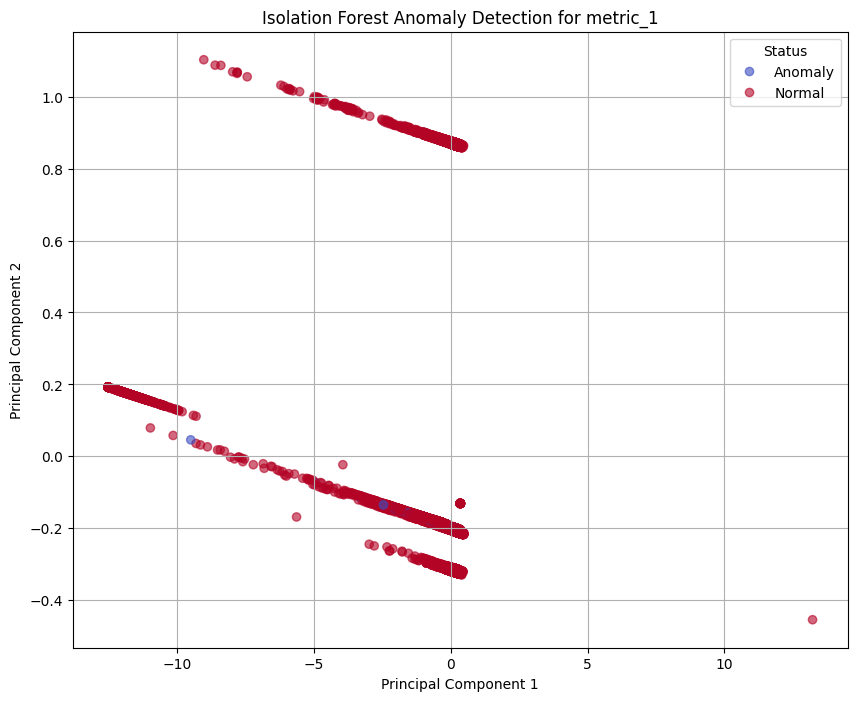

-----------------------------------

--- Running Autoencoder for Anomaly Detection (PyTorch) ---
--- PCA model saved successfully ---
Data reduced to 60 principal components for training.
Explained variance: 1.0000
Phase 1: Unsupervised pre-training...
Pre-training complete.
Phase 2: Supervised fine-tuning...
Fine-tuning complete.
Classifier head detected 28106163 anomalies.
Autoencoder model saved to trained_models/metric_1_autoencoder.pth

--- Generating Plots for Classification Head Anomaly Detection ---


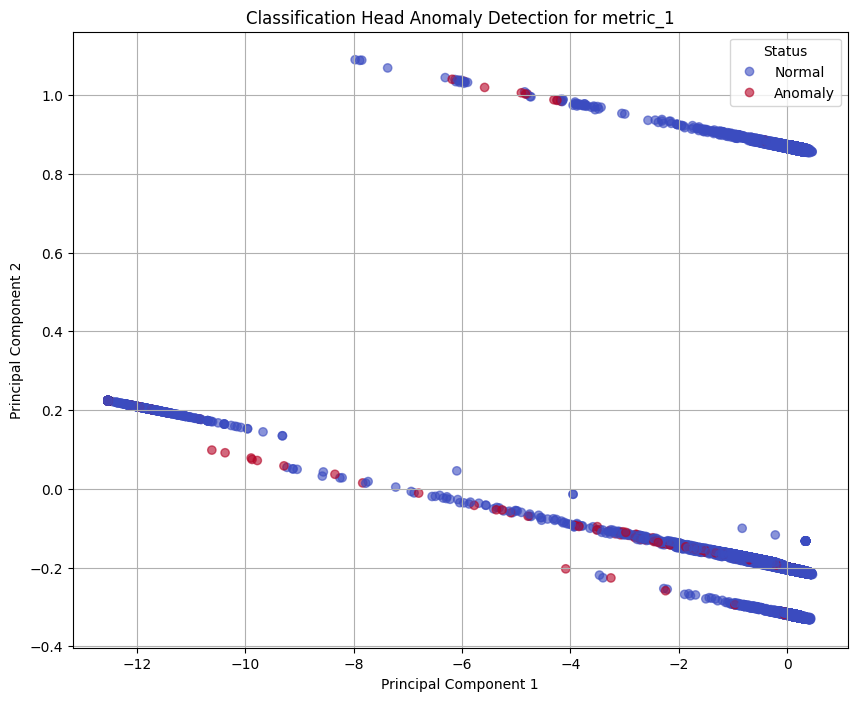

-----------------------------------
|  Processing Data for: METRIC_2  |
Data loaded successfully.

--- Scaler and Encoder saved successfully ---

--- Preprocessing Complete ---
Final feature matrix shape: (28352261, 62)
Data type: <class 'scipy.sparse._coo.coo_matrix'>
-----------------------------------

--- Running Isolation Forest for Anomaly Detection ---
Isolation Forest detected 283135 anomalies.
Isolation Forest model saved to trained_models/metric_2_isolation_forest.joblib

--- Generating Plots for Isolation Forest Anomaly Detection ---


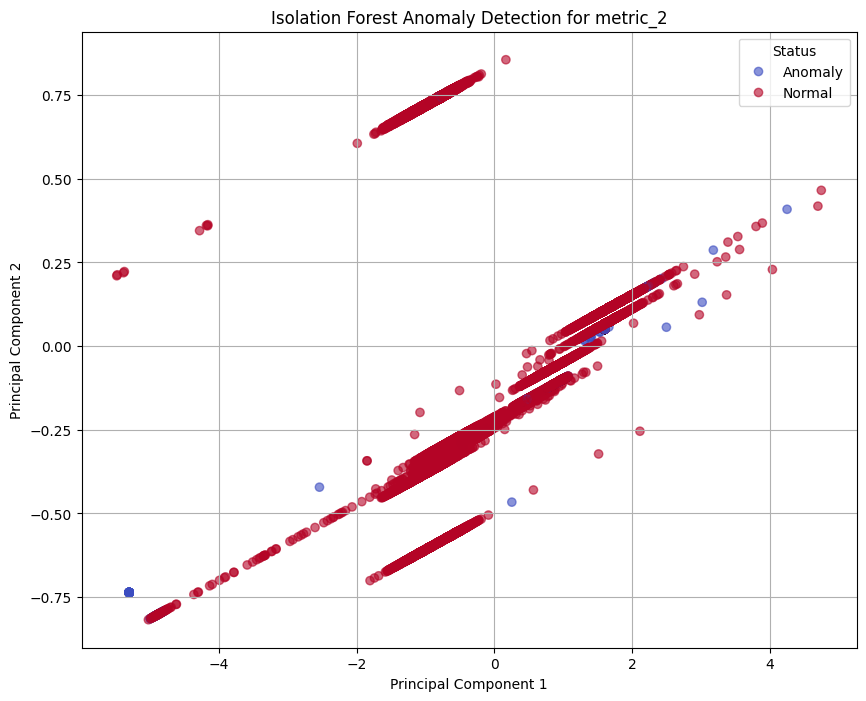

-----------------------------------

--- Running Autoencoder for Anomaly Detection (PyTorch) ---
--- PCA model saved successfully ---
Data reduced to 60 principal components for training.
Explained variance: 1.0000
Phase 1: Unsupervised pre-training...
Pre-training complete.
Phase 2: Supervised fine-tuning...
Fine-tuning complete.
Classifier head detected 28352261 anomalies.
Autoencoder model saved to trained_models/metric_2_autoencoder.pth

--- Generating Plots for Classification Head Anomaly Detection ---


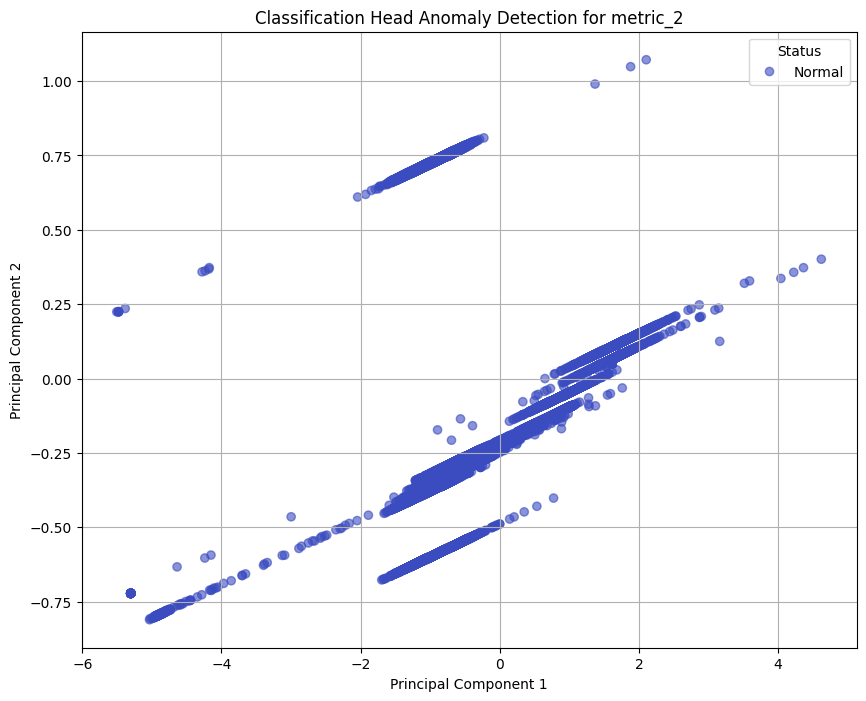

-----------------------------------
|  Processing Data for: METRIC_3  |
Data loaded successfully.

--- Scaler and Encoder saved successfully ---

--- Preprocessing Complete ---
Final feature matrix shape: (28727444, 62)
Data type: <class 'scipy.sparse._coo.coo_matrix'>
-----------------------------------

--- Running Isolation Forest for Anomaly Detection ---
Isolation Forest detected 102113 anomalies.
Isolation Forest model saved to trained_models/metric_3_isolation_forest.joblib

--- Generating Plots for Isolation Forest Anomaly Detection ---


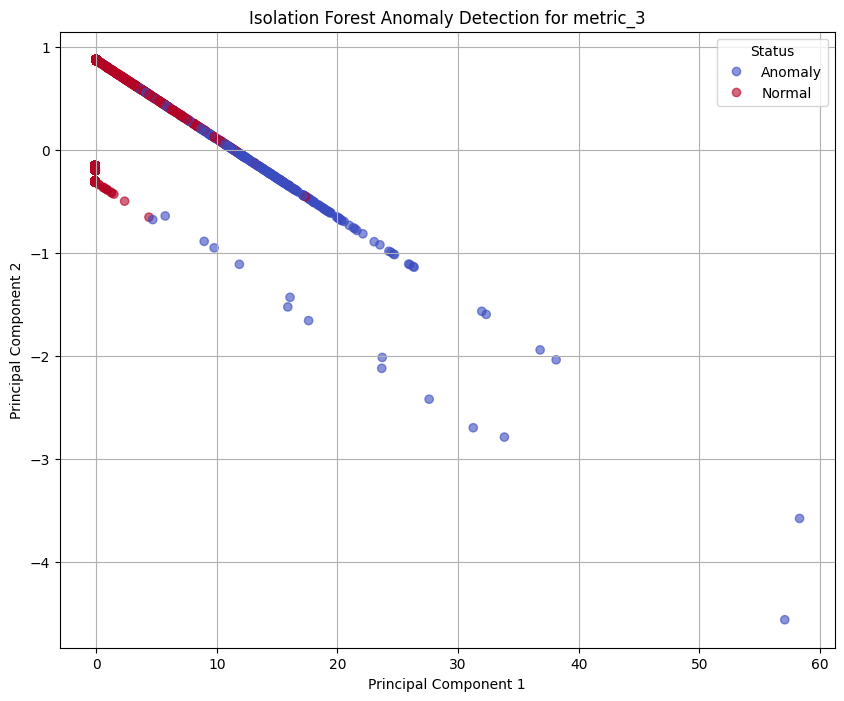

-----------------------------------

--- Running Autoencoder for Anomaly Detection (PyTorch) ---
--- PCA model saved successfully ---
Data reduced to 60 principal components for training.
Explained variance: 1.0000
Phase 1: Unsupervised pre-training...
Pre-training complete.
Phase 2: Supervised fine-tuning...
Fine-tuning complete.
Classifier head detected 28521100 anomalies.
Autoencoder model saved to trained_models/metric_3_autoencoder.pth

--- Generating Plots for Classification Head Anomaly Detection ---


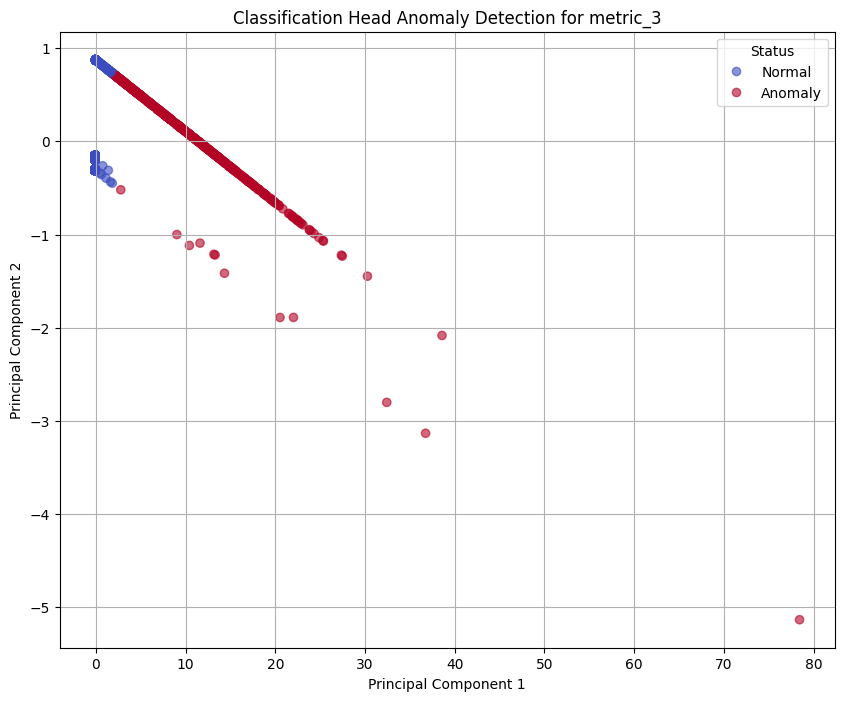

-----------------------------------


In [20]:
# --- Main execution ---
if __name__ == "__main__":
    run_pipeline_for_metrics()

In [5]:
import glob
import os

import pandas as pd
METRIC_1_FOLDER = r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\metric_1_files"
METRIC_2_FOLDER = r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\metric_2_files"
METRIC_3_FOLDER = r"C:\Users\anurj\Desktop\Journey to Greatness\7G Hackathon\metric_3_files"



def main():
    """
    Main function to orchestrate the data merging process.
    """
    # Create a list of tuples with folder paths and corresponding metric names
    folders_to_process = [
        (METRIC_1_FOLDER, 'metric_1'),
        (METRIC_2_FOLDER, 'metric_2'),
        (METRIC_3_FOLDER, 'metric_3')
    ]

    processed_count = 0
    # Process each folder and save the resulting DataFrame to a separate file
    for folder_path, metric_name in folders_to_process:

        # Find all CSV files in the folder
        csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
        if not csv_files:
            print(f"No CSV files found for {metric_name} in {folder_path}. Skipping.")
            continue

        # Read and concatenate all CSV files
        df_list = []
        for file in csv_files:
            try:
                df = pd.read_csv(file, sep=';')
                df_list.append(df)
            except Exception as e:
                print(f"Error reading {file}: {e}")

        if not df_list:
            print(f"No valid data found for {metric_name}. Skipping.")
            continue

        # Concatenate all DataFrames in the list
        merged_df = pd.concat(df_list, ignore_index=True)

        # Convert Datetime column to datetime type if present
        if 'Datetime(UTC)' in merged_df.columns:
            merged_df['Datetime(UTC)'] = pd.to_datetime(merged_df['Datetime(UTC)'])
            merged_df = merged_df.sort_values(by=['Datetime(UTC)', 'instance']).reset_index(drop=True)

        output_filename = f"{metric_name}_val_data.csv"
        merged_df.to_csv(output_filename, sep=';', index=False)

        print(f"\nSuccessfully merged CSV files for {metric_name}.")
        print(f"Data saved to '{output_filename}'.")
        print("------------------------------------------")
        print("Example of the first 5 rows:")
        print(merged_df.head().to_string())
        print("------------------------------------------")
        processed_count += 1

    if processed_count == 0:
        print("No data was processed. Please check your folder paths and file formats.")
    else:
        print(f"\nFinished processing. Created {processed_count} separate CSV files.")


if __name__ == "__main__":
    main()


Successfully merged CSV files for metric_1.
Data saved to 'metric_1_val_data.csv'.
------------------------------------------
Example of the first 5 rows:
        Datetime(UTC)     value datacenter    instance
0 2025-07-28 05:00:10  0.976841    region1   instance1
1 2025-07-28 05:00:10  0.915858    region4  instance10
2 2025-07-28 05:00:10  0.963402    region5  instance11
3 2025-07-28 05:00:10  0.953578    region5  instance12
4 2025-07-28 05:00:10  0.981753    region6  instance13
------------------------------------------

Successfully merged CSV files for metric_2.
Data saved to 'metric_2_val_data.csv'.
------------------------------------------
Example of the first 5 rows:
        Datetime(UTC)     value datacenter    instance
0 2025-07-28 05:00:10  0.996408    region1   instance1
1 2025-07-28 05:00:10       NaN    region4  instance10
2 2025-07-28 05:00:10  0.602059    region5  instance11
3 2025-07-28 05:00:10  0.565429    region5  instance12
4 2025-07-28 05:00:10  0.678499    regio

In [21]:


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class AutoencoderClassifier(nn.Module):
    """
    Autoencoder with a classification head for semi-supervised learning.
    """
    def __init__(self, input_dim):
        super(AutoencoderClassifier, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

        # Classification head for binary classification
        self.classification_head = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, mode='reconstruction'):
        encoded = self.encoder(x)
        if mode == 'reconstruction':
            return self.decoder(encoded)
        elif mode == 'classification':
            return self.classification_head(encoded)
        else:
            raise ValueError("Invalid mode. Use 'reconstruction' or 'classification'.")

def run_inference_pipeline(test_file_path, metric_name, model_dir):
    """
    Loads trained models and makes predictions on a new test set.
    Saves the results to a new CSV file.
    """
    print(f"===========================================================")
    print(f"|  Inference for: {metric_name.upper()}  |")
    print(f"===========================================================")
    
    # --- Load Test Data ---
    try:
        df_test = pd.read_csv(test_file_path, sep=';')
        print(f"Test data loaded successfully from {test_file_path}.")
    except FileNotFoundError:
        print(f"Error: Test file '{test_file_path}' not found.")
        return
    except Exception as e:
        print(f"An error occurred loading the test file: {e}")
        return

    # --- Initial Anomaly Assignment for NaN/inf values ---
    df_test['anomaly_iso_forest'] = 1
    df_test['anomaly_class_head'] = 1

    # Find indices where 'value' is NaN or infinite
    nan_inf_indices = df_test['value'].isnull() | np.isinf(df_test['value'])
    
    # Assign anomaly label 0 to these rows
    df_test.loc[nan_inf_indices, 'anomaly_iso_forest'] = 0
    df_test.loc[nan_inf_indices, 'anomaly_class_head'] = 0

    # Create a clean DataFrame for model inference
    df_clean = df_test.loc[~nan_inf_indices].copy()
    
    if df_clean.empty:
        print("Warning: No clean data to process after filtering NaN/inf values.")
        return

    # --- Load Preprocessing Objects ---
    try:
        scaler = joblib.load(os.path.join(model_dir, f"{metric_name}_scaler.joblib"))
        encoder = joblib.load(os.path.join(model_dir, f"{metric_name}_encoder.joblib"))
    except FileNotFoundError as e:
        print(f"Error loading preprocessing objects for {metric_name}: {e}")
        print("Please ensure the training pipeline has been run successfully.")
        return

    # --- Preprocess Clean Data ---
    numerical_features = ['value']
    categorical_features = ['datacenter', 'instance']

    df_scaled_array = scaler.transform(df_clean[numerical_features])
    df_encoded_sparse = encoder.transform(df_clean[categorical_features])
    X_sparse_test = hstack([df_scaled_array, df_encoded_sparse])
    
    # --- Make Predictions with Isolation Forest ---
    print("\n--- Making predictions with Isolation Forest ---")
    try:
        iso_forest = joblib.load(os.path.join(model_dir, f"{metric_name}_isolation_forest.joblib"))
        predictions_iso = iso_forest.predict(X_sparse_test)
        
        # Map predictions: -1 (anomaly) -> 0, 1 (normal) -> 1
        df_clean['anomaly_iso_forest'] = np.where(predictions_iso == -1, 0, 1)
        
        # Merge predictions back into the original dataframe
        df_test.loc[~nan_inf_indices, 'anomaly_iso_forest'] = df_clean['anomaly_iso_forest']

        print("Isolation Forest predictions complete.")
    except FileNotFoundError as e:
        print(f"Error: Isolation Forest model for {metric_name} not found.")
        return

    # --- Make Predictions with Autoencoder ---
    print("\n--- Making predictions with Autoencoder ---")
    try:
        pca = joblib.load(os.path.join(model_dir, f"{metric_name}_pca.joblib"))
        model = AutoencoderClassifier(pca.n_components).to(device)
        model.load_state_dict(torch.load(os.path.join(model_dir, f"{metric_name}_autoencoder.pth")))
        model.eval()
        
        batch_size_predict = 10000
        all_predictions = []
        
        X_csr_test = X_sparse_test.tocsr()

        with torch.no_grad():
            for i in range(0, X_csr_test.shape[0], batch_size_predict):
                batch_sparse = X_csr_test[i:i + batch_size_predict, :]
                batch_dense = batch_sparse.toarray()
                transformed_batch = pca.transform(batch_dense)
                tensor_batch = torch.tensor(transformed_batch, dtype=torch.float32).to(device)
                predictions = model(tensor_batch, mode='classification').cpu().numpy()
                all_predictions.append(predictions)

        all_predictions = np.vstack(all_predictions)
        
        # Map predictions: >0.5 -> 0 (anomaly), <=0.5 -> 1 (normal)
        df_clean['anomaly_class_head'] = (all_predictions <= 0.5).astype(int)
        
        # Merge predictions back into the original dataframe
        df_test.loc[~nan_inf_indices, 'anomaly_class_head'] = df_clean['anomaly_class_head']
       

        print("Autoencoder predictions complete.")

    except FileNotFoundError as e:
        print(f"Error: Autoencoder model for {metric_name} not found.")
        return
    except Exception as e:
        print(f"An error occurred during autoencoder inference: {e}")
        return

    # --- Save Results to CSV ---
    output_path = f"{metric_name}_predictions.csv"
    df_test.to_csv(output_path, sep=';', index=False)
    print(f"\nPredictions saved to {output_path}")
    print("Inference pipeline complete.")
    print("-" * 35)

if __name__ == "__main__":
    # --- User-configurable settings ---
    for i in range(1,4):
        test_file = f"C:/Users/anurj/Desktop/Journey to Greatness/7G Hackathon/Codes/metric_{i}_val_data.csv"
        trained_models_dir = "trained_models"
        metric_name_to_run = f"metric_{i}"
        
        run_inference_pipeline(test_file, metric_name_to_run, trained_models_dir)


Using device: cuda
|  Inference for: METRIC_1  |
Test data loaded successfully from C:/Users/anurj/Desktop/Journey to Greatness/7G Hackathon/Codes/metric_1_val_data.csv.

--- Making predictions with Isolation Forest ---
Isolation Forest predictions complete.

--- Making predictions with Autoencoder ---
Autoencoder predictions complete.

Predictions saved to metric_1_predictions.csv
Inference pipeline complete.
-----------------------------------
|  Inference for: METRIC_2  |
Test data loaded successfully from C:/Users/anurj/Desktop/Journey to Greatness/7G Hackathon/Codes/metric_2_val_data.csv.

--- Making predictions with Isolation Forest ---
Isolation Forest predictions complete.

--- Making predictions with Autoencoder ---
Autoencoder predictions complete.

Predictions saved to metric_2_predictions.csv
Inference pipeline complete.
-----------------------------------
|  Inference for: METRIC_3  |
Test data loaded successfully from C:/Users/anurj/Desktop/Journey to Greatness/7G Hackath

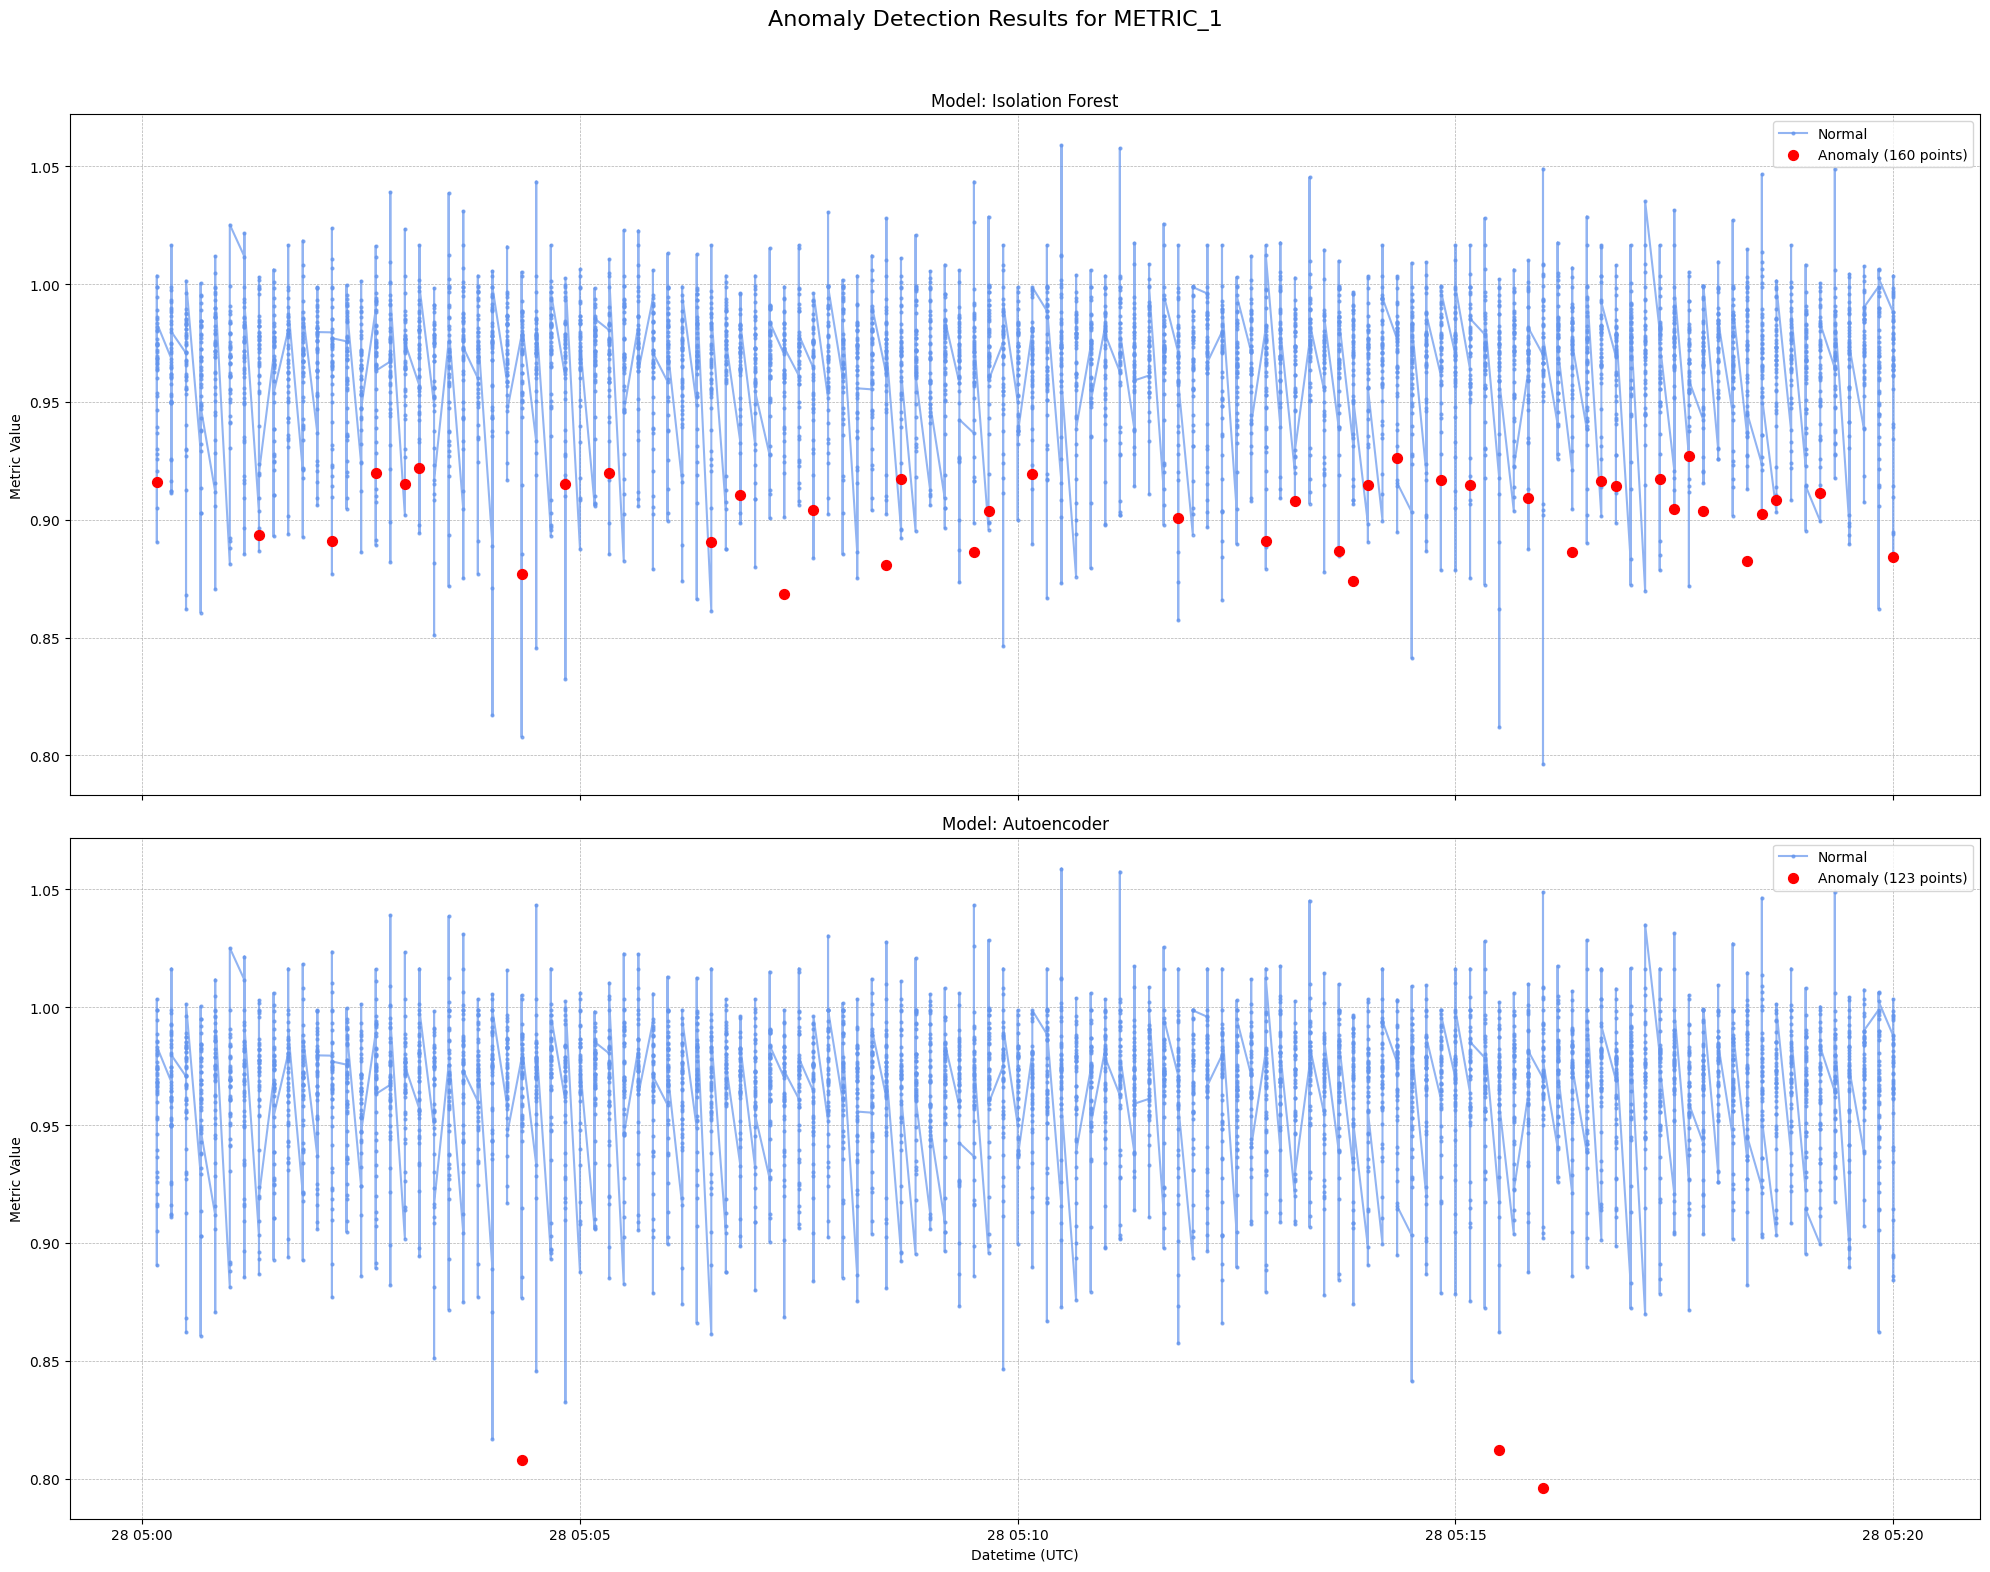

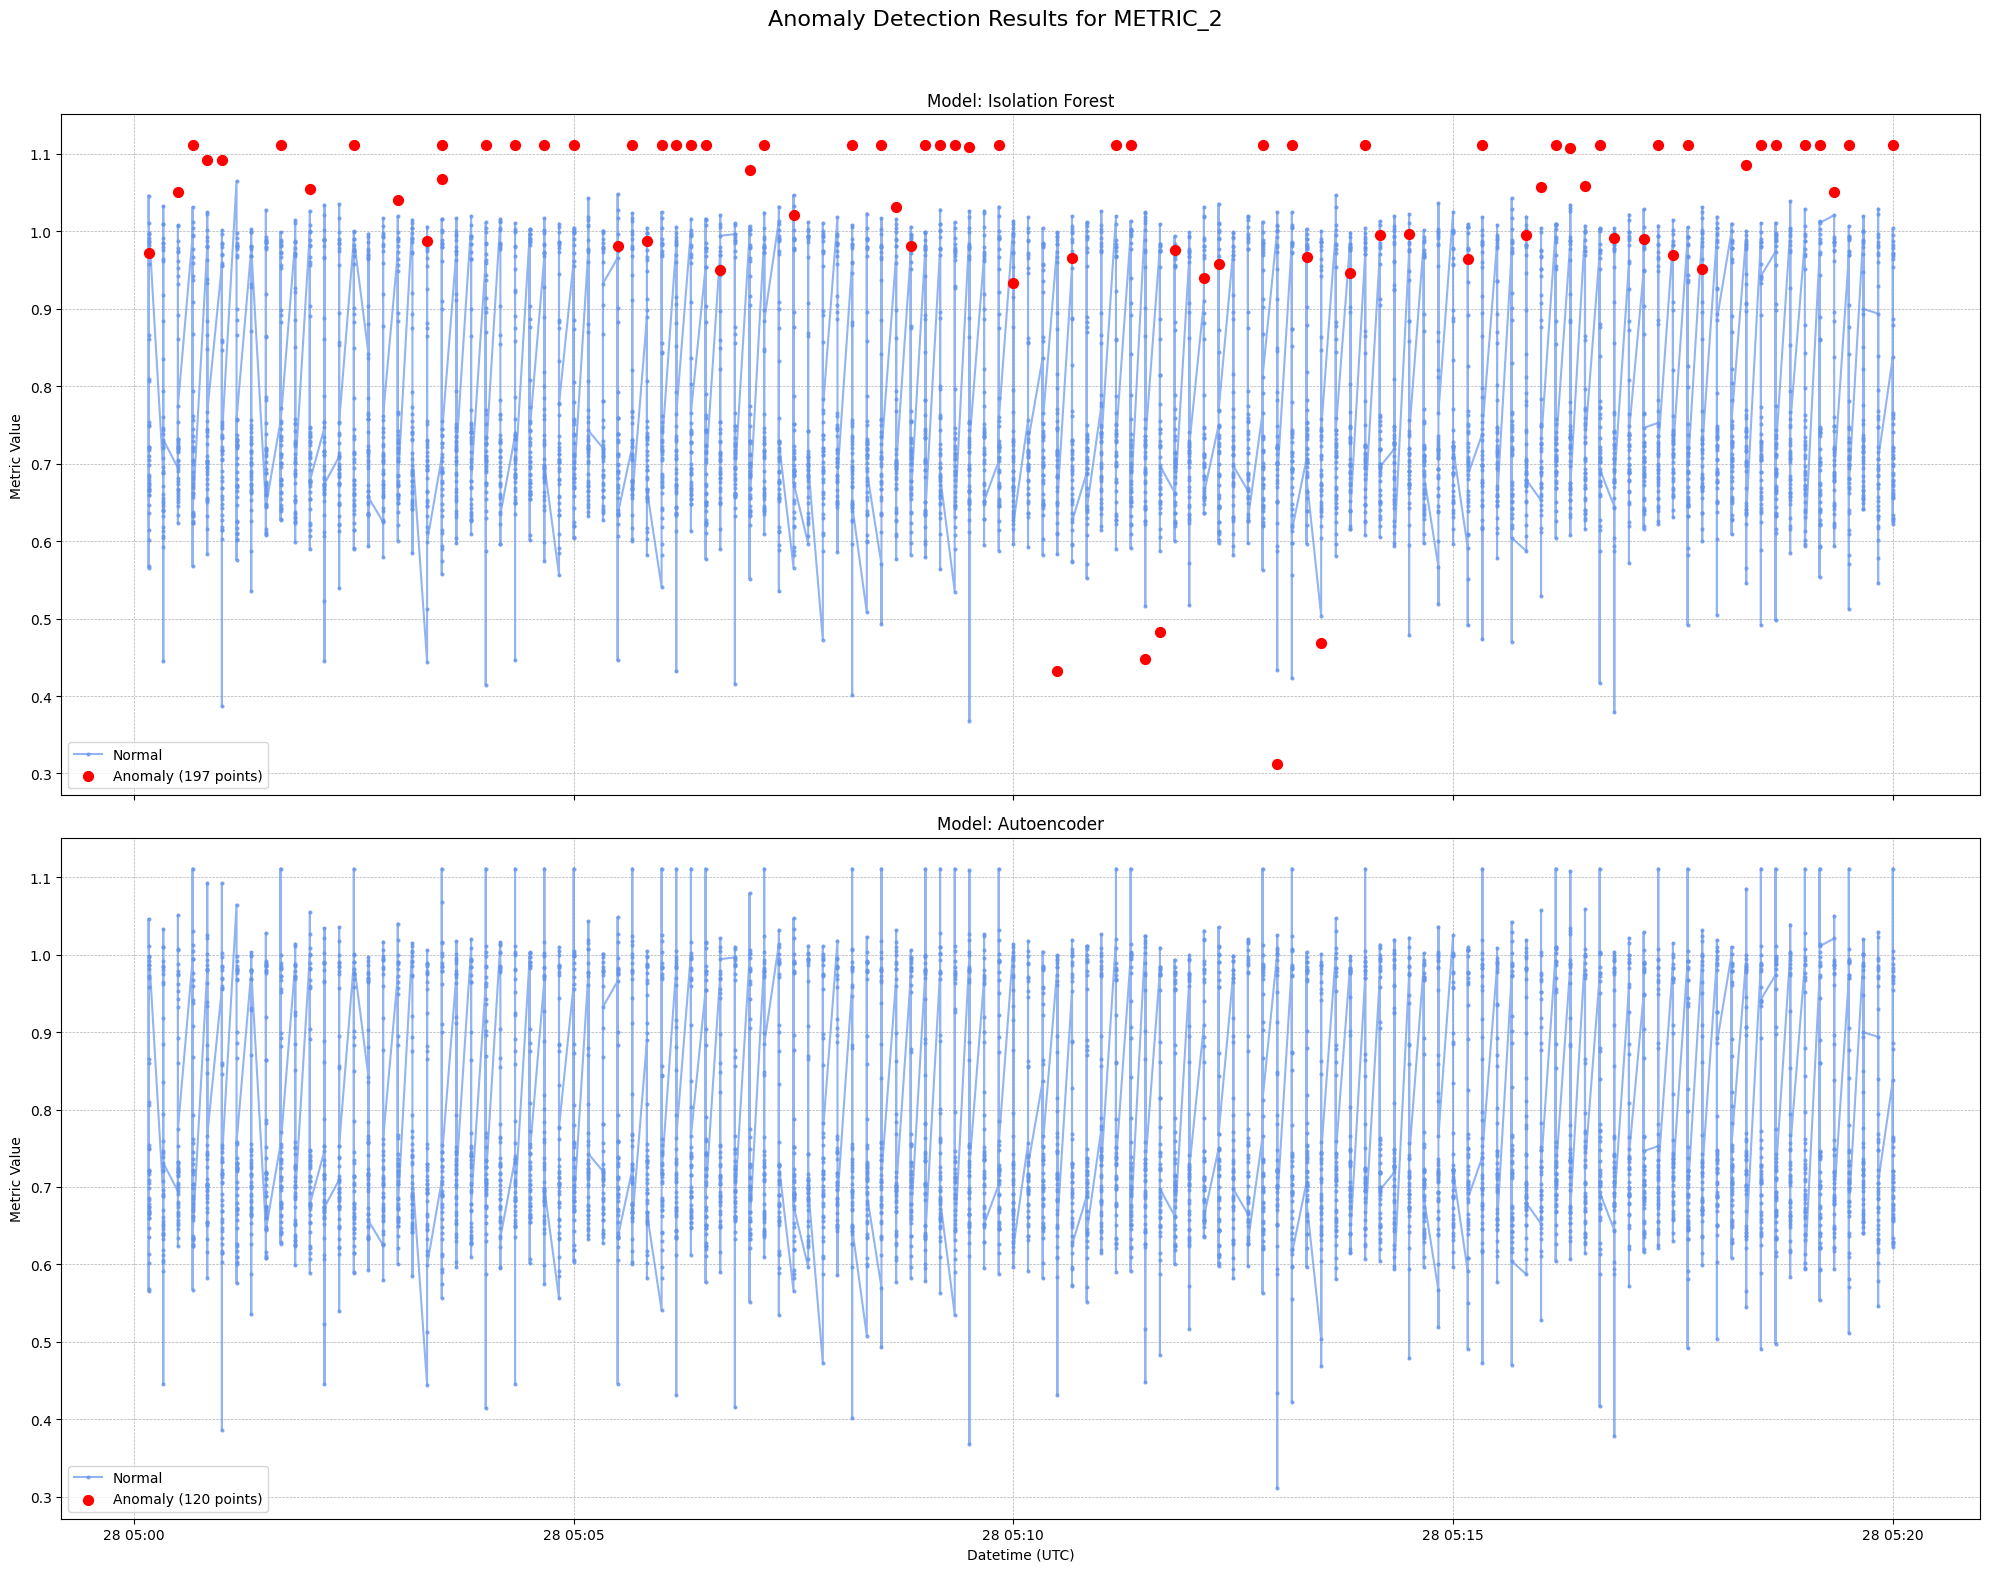

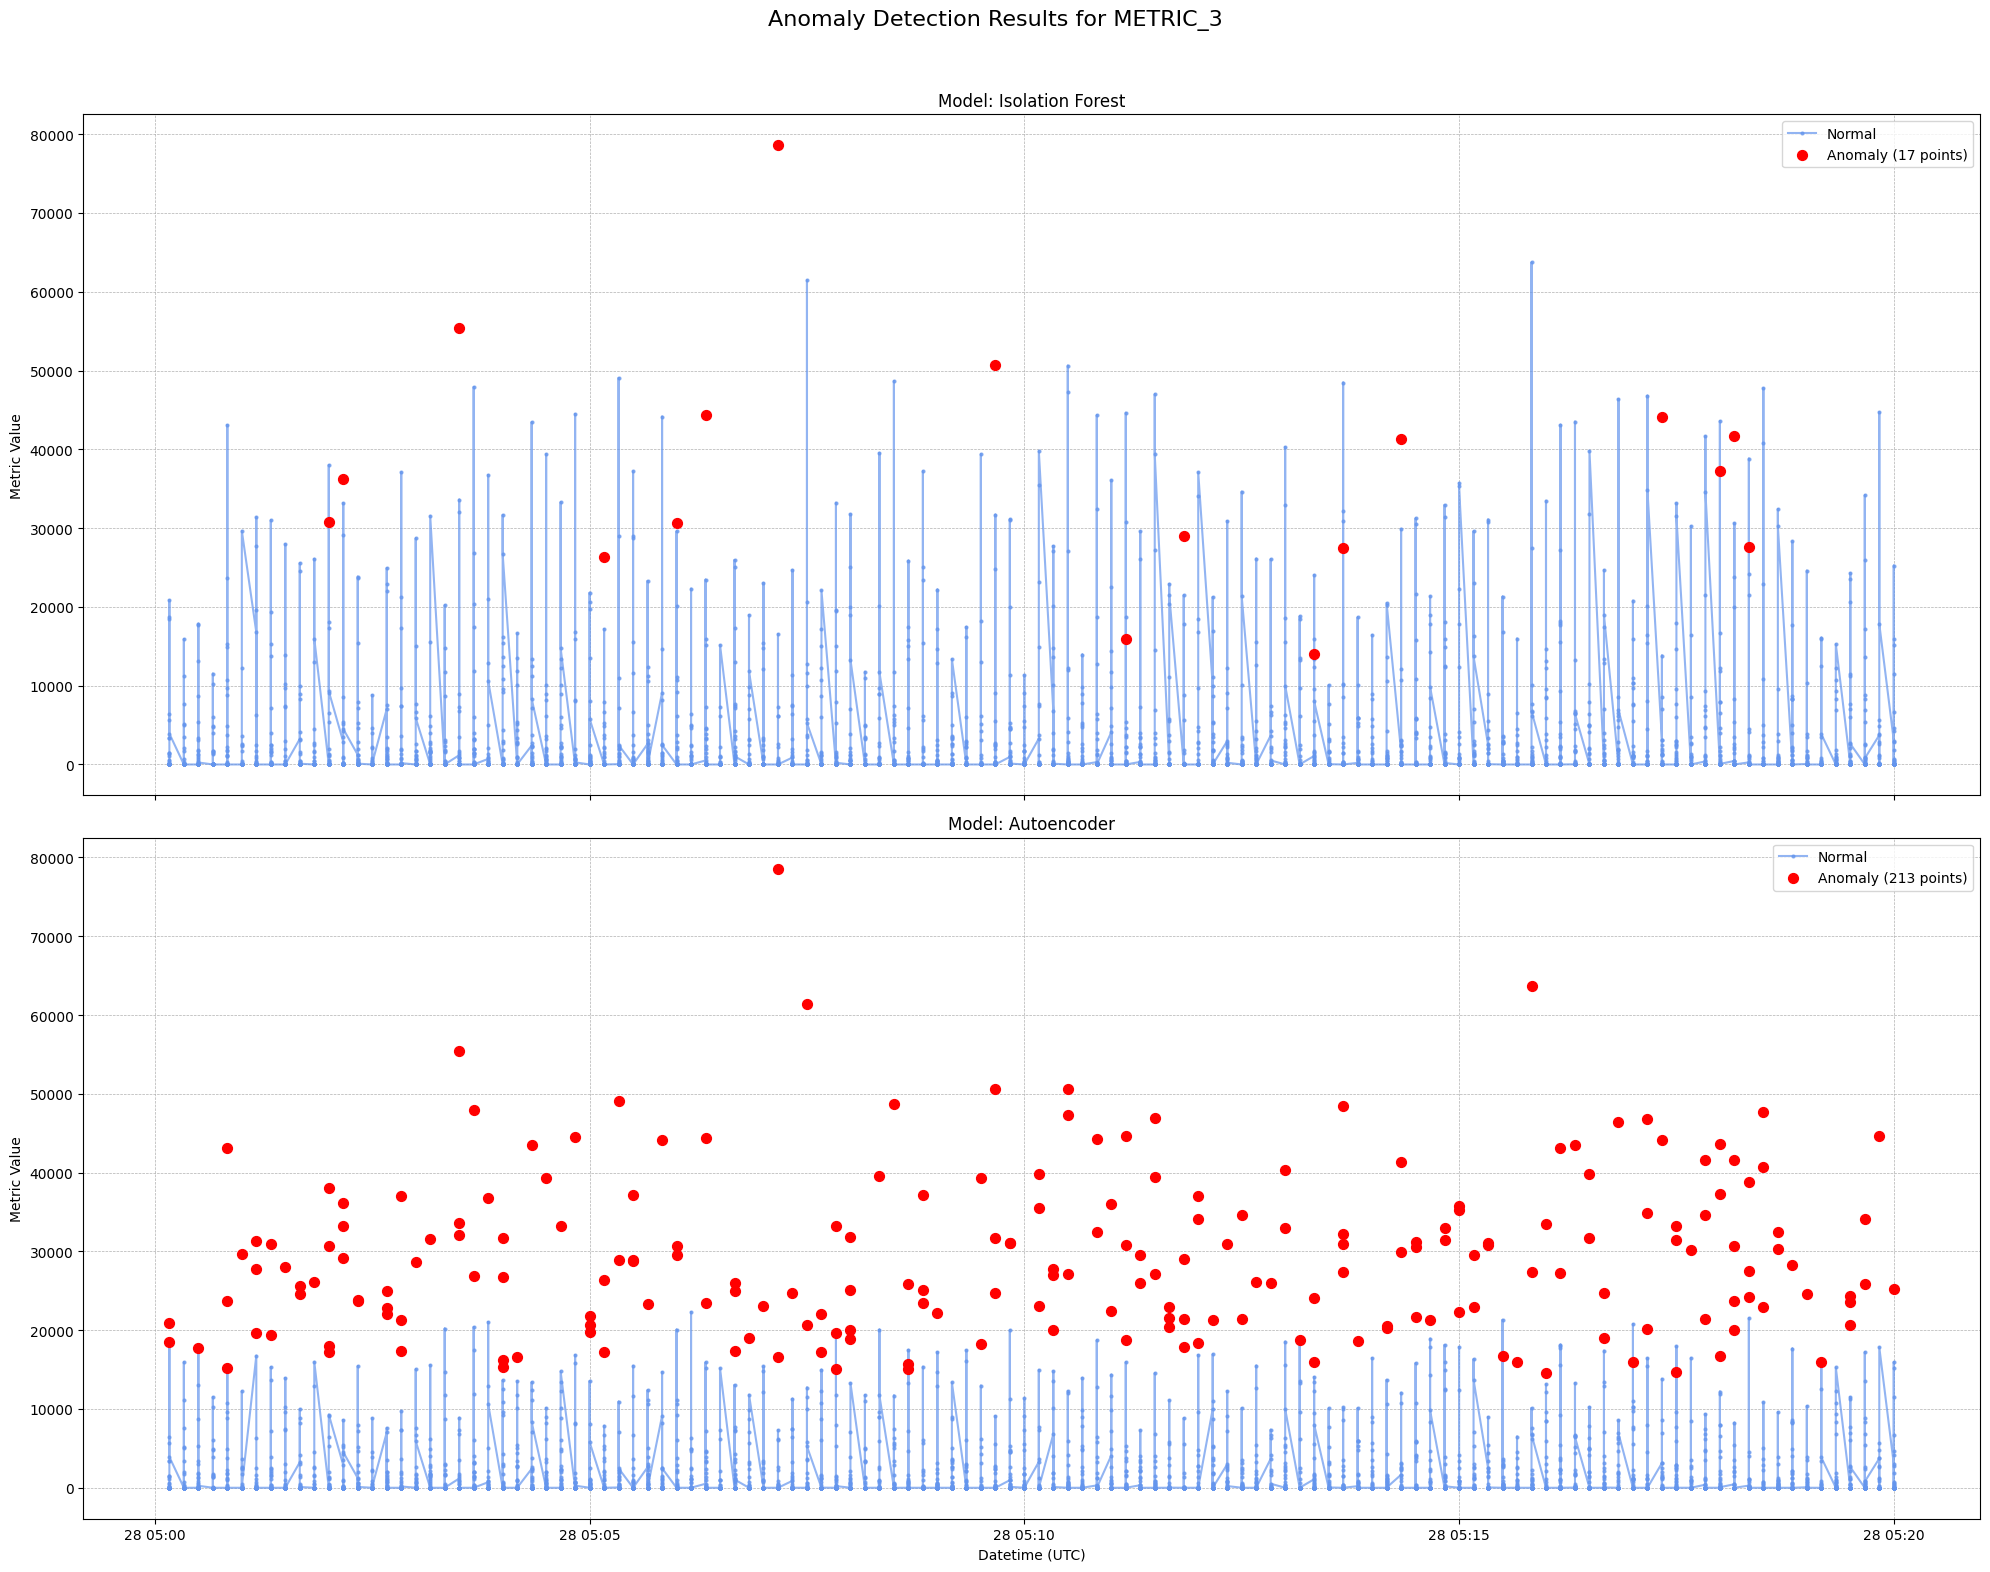

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_anomaly_results(prediction_file, metric_name):
    """
    Loads a prediction file and plots the time series data, highlighting anomalies
    for both Isolation Forest and Autoencoder models.
    """
    try:
        df = pd.read_csv(prediction_file, sep=';')
    except FileNotFoundError:
        print(f"Prediction file not found: {prediction_file}. Skipping.")
        return

    # Ensure Datetime column is in datetime format for proper plotting
    if 'Datetime(UTC)' not in df.columns:
        print(f"'Datetime(UTC)' column not found in {prediction_file}. Cannot plot.")
        return
    df['Datetime(UTC)'] = pd.to_datetime(df['Datetime(UTC)'])
    df = df.sort_values('Datetime(UTC)')

    # Define the models and their corresponding prediction columns
    models = {
        'Isolation Forest': 'anomaly_iso_forest',
        'Autoencoder': 'anomaly_class_head'
    }

    # Create a figure with two subplots (one for each model)
    fig, axes = plt.subplots(len(models), 1, figsize=(20, 16), sharex=True)
    fig.suptitle(f'Anomaly Detection Results for {metric_name.upper()}', fontsize=16)

    for i, (model_name, col_name) in enumerate(models.items()):
        if col_name not in df.columns:
            print(f"Prediction column '{col_name}' not found for {model_name}. Skipping plot.")
            continue

        ax = axes[i]
        
        # Separate normal data and anomalies
        normal_data = df[df[col_name] == 1]
        anomalies = df[df[col_name] == 0]

        # Plot normal data points
        ax.plot(normal_data['Datetime(UTC)'], normal_data['value'], 
                label='Normal', color='cornflowerblue', linestyle='-', marker='.', markersize=4, alpha=0.7)

        # Plot anomalies to highlight them
        ax.scatter(anomalies['Datetime(UTC)'], anomalies['value'], 
                   color='red', label=f'Anomaly ({len(anomalies)} points)', marker='o', s=50, zorder=5)

        ax.set_title(f'Model: {model_name}', fontsize=12)
        ax.set_ylabel('Metric Value')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.xlabel('Datetime (UTC)')
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()


# --- Main execution to plot results for all metrics ---
for i in range(1, 4):
    metric_name_to_plot = f"metric_{i}"
    file_to_plot = f"{metric_name_to_plot}_predictions.csv"
    
    if os.path.exists(file_to_plot):
        plot_anomaly_results(file_to_plot, metric_name_to_plot)
    else:
        print(f"Could not find prediction file: {file_to_plot}")

In [33]:
for i in range(1, 4):
    metric_name_to_plot = f"metric_{i}"
    file_to_plot = f"{metric_name_to_plot}_predictions.csv"
    
    data= pd.read_csv(file_to_plot, sep=';')
    df = pd.DataFrame(data)
    df.describe()
    print("=============================================")
    print(df.info())
    print("=============================================")
    print(df.value_counts(['anomaly_iso_forest']))
    print("=============================================")
    print(df.value_counts(['anomaly_class_head']))
    print("=============================================")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280 entries, 0 to 5279
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Datetime(UTC)       5280 non-null   object 
 1   value               5227 non-null   float64
 2   datacenter          5280 non-null   object 
 3   instance            5280 non-null   object 
 4   anomaly_iso_forest  5280 non-null   int64  
 5   anomaly_class_head  5280 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 247.6+ KB
None
anomaly_iso_forest
1                     5120
0                      160
Name: count, dtype: int64
anomaly_class_head
1                     5157
0                      123
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280 entries, 0 to 5279
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Datetime(UTC)       5280 n

c:\Users\anurj\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\anurj\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

def plot_anomaly_results_by_interval(prediction_file, metric_name, interval='5T'):
    """
    Loads a prediction file, groups data into time intervals, and creates a separate
    plot for each interval to visualize anomalies.
    """
    try:
        df = pd.read_csv(prediction_file, sep=';')
    except FileNotFoundError:
        print(f"Prediction file not found: {prediction_file}. Skipping.")
        return

    if 'Datetime(UTC)' not in df.columns:
        print(f"'Datetime(UTC)' column not found in {prediction_file}. Cannot plot.")
        return
        
    df['Datetime(UTC)'] = pd.to_datetime(df['Datetime(UTC)'])
    df = df.sort_values('Datetime(UTC)').set_index('Datetime(UTC)')

    # Create a grouper for the specified time interval
    grouper = pd.Grouper(freq=interval)
    
    # Group the DataFrame by the time interval
    grouped = df.groupby(grouper)

    models = {
        'Isolation Forest': 'anomaly_iso_forest',
        'Autoencoder': 'anomaly_class_head'
    }

    print(f"\n--- Generating plots for {metric_name.upper()} in {interval} intervals ---")

    # Iterate over each time interval group
    for group_name, group_df in grouped:
        if group_df.empty:
            continue

        # Create a figure with subplots for each model
        fig, axes = plt.subplots(len(models), 1, figsize=(15, 12), sharex=True)
        fig.suptitle(f'Anomaly Detection for {metric_name.upper()}\nInterval: {group_name.strftime("%Y-%m-%d %H:%M:%S")} to {(group_name + pd.Timedelta(interval)).strftime("%H:%M:%S")}', fontsize=16)

        for i, (model_name, col_name) in enumerate(models.items()):
            if col_name not in group_df.columns:
                print(f"Prediction column '{col_name}' not found. Skipping plot for {model_name}.")
                continue

            ax = axes[i] if len(models) > 1 else axes
            
            # Separate normal data and anomalies within the group
            normal_data = group_df[group_df[col_name] == 1]
            anomalies = group_df[group_df[col_name] == 0]

            # Plot normal data points
            ax.plot(normal_data.index, normal_data['value'], 
                    label='Normal', color='cornflowerblue', linestyle='None', marker='.', markersize=8)

            # Plot anomalies to highlight them
            ax.scatter(anomalies.index, anomalies['value'], 
                       color='red', label=f'Anomaly ({len(anomalies)} points)', marker='o', s=60, zorder=5)

            ax.set_title(f'Model: {model_name}', fontsize=12)
            ax.set_ylabel('Metric Value')
            ax.legend()
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # Format x-axis to show time
            ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M:%S'))

        plt.xlabel('Time (UTC)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# --- Main execution to plot results for all metrics ---
for i in range(1, 4):
    metric_name_to_plot = f"metric_{i}"
    file_to_plot = f"{metric_name_to_plot}_predictions.csv"
    
    if os.path.exists(file_to_plot):
        plot_anomaly_results_by_interval(file_to_plot, metric_name_to_plot, interval='5T')
    else:
        print(f"Could not find prediction file: {file_to_plot}")

In [1]:
import pandas as pd
import os

# Loop through each metric from 1 to 3
for i in range(1, 4):
    # Construct the file name for the prediction file
    prediction_file = f"metric_{i}_predictions.csv"

    # Check if the prediction file exists
    if os.path.exists(prediction_file):
        print(f"Processing file: {prediction_file}")

        # Read the data from the CSV file
        df = pd.read_csv(prediction_file, sep=';')

        # Define the columns where values need to be swapped
        target_columns = ['anomaly_iso_forest', 'anomaly_class_head']

        # Iterate over the target columns to swap the values
        for col in target_columns:
            if col in df.columns:
                # Use a mapping to swap 0s and 1s
                df[col] = df[col].map({0: 1, 1: 0})
                print(f"  - Values in '{col}' have been swapped.")
            else:
                print(f"  - Column '{col}' not found in {prediction_file}.")

        # Save the modified DataFrame back to the same CSV file
        df.to_csv(prediction_file, sep=';', index=False)
        print(f"Successfully updated and saved {prediction_file}\n")
    else:
        print(f"File not found: {prediction_file}. Skipping.")

Processing file: metric_1_predictions.csv
  - Values in 'anomaly_iso_forest' have been swapped.
  - Values in 'anomaly_class_head' have been swapped.
Successfully updated and saved metric_1_predictions.csv

Processing file: metric_2_predictions.csv
  - Values in 'anomaly_iso_forest' have been swapped.
  - Values in 'anomaly_class_head' have been swapped.
Successfully updated and saved metric_2_predictions.csv

Processing file: metric_3_predictions.csv
  - Values in 'anomaly_iso_forest' have been swapped.
  - Values in 'anomaly_class_head' have been swapped.
Successfully updated and saved metric_3_predictions.csv



In [2]:
for i in range(1, 4):
    metric_name_to_plot = f"metric_{i}"
    file_to_plot = f"{metric_name_to_plot}_predictions.csv"
    
    data= pd.read_csv(file_to_plot, sep=';')
    df = pd.DataFrame(data)
    df.describe()
    print("=============================================")
    print(df.info())
    print("=============================================")
    print(df.value_counts(['anomaly_iso_forest']))
    print("=============================================")
    print(df.value_counts(['anomaly_class_head']))
    print("=============================================")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280 entries, 0 to 5279
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Datetime(UTC)       5280 non-null   object 
 1   value               5227 non-null   float64
 2   datacenter          5280 non-null   object 
 3   instance            5280 non-null   object 
 4   anomaly_iso_forest  5280 non-null   int64  
 5   anomaly_class_head  5280 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 247.6+ KB
None
anomaly_iso_forest
0                     5120
1                      160
Name: count, dtype: int64
anomaly_class_head
0                     5157
1                      123
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280 entries, 0 to 5279
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Datetime(UTC)       5280 n

c:\Users\anurj\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\anurj\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class AutoencoderClassifier(nn.Module):
    """
    Autoencoder with a classification head for semi-supervised learning.
    """
    def __init__(self, input_dim):
        super(AutoencoderClassifier, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

        # Classification head for binary classification
        self.classification_head = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, mode='reconstruction'):
        encoded = self.encoder(x)
        if mode == 'reconstruction':
            return self.decoder(encoded)
        elif mode == 'classification':
            return self.classification_head(encoded)
        else:
            raise ValueError("Invalid mode. Use 'reconstruction' or 'classification'.")

def run_inference_pipeline(test_file_path, metric_name, model_dir):
    """
    Loads trained models and makes predictions on a new test set.
    Saves the results to a new CSV file.
    """
    print(f"===========================================================")
    print(f"|  Inference for: {metric_name.upper()}  |")
    print(f"===========================================================")
    
    # --- Load Test Data ---
    try:
        df_test = pd.read_csv(test_file_path, sep=';')
        print(f"Test data loaded successfully from {test_file_path}.")
    except FileNotFoundError:
        print(f"Error: Test file '{test_file_path}' not found.")
        return
    except Exception as e:
        print(f"An error occurred loading the test file: {e}")
        return

    # --- Initial Anomaly Assignment for NaN/inf values ---
    df_test['anomaly_iso_forest'] = 1
    df_test['anomaly_class_head'] = 1

    # Find indices where 'value' is NaN or infinite
    nan_inf_indices = df_test['value'].isnull() | np.isinf(df_test['value'])
    
    # Assign anomaly label 0 to these rows
    df_test.loc[nan_inf_indices, 'anomaly_iso_forest'] = 0
    df_test.loc[nan_inf_indices, 'anomaly_class_head'] = 0

    # Create a clean DataFrame for model inference
    df_clean = df_test.loc[~nan_inf_indices].copy()
    
    if df_clean.empty:
        print("Warning: No clean data to process after filtering NaN/inf values.")
        return

    # --- Load Preprocessing Objects ---
    try:
        scaler = joblib.load(os.path.join(model_dir, f"{metric_name}_scaler.joblib"))
        encoder = joblib.load(os.path.join(model_dir, f"{metric_name}_encoder.joblib"))
    except FileNotFoundError as e:
        print(f"Error loading preprocessing objects for {metric_name}: {e}")
        print("Please ensure the training pipeline has been run successfully.")
        return

    # --- Preprocess Clean Data ---
    numerical_features = ['value']
    categorical_features = ['datacenter', 'instance']

    df_scaled_array = scaler.transform(df_clean[numerical_features])
    df_encoded_sparse = encoder.transform(df_clean[categorical_features])
    X_sparse_test = hstack([df_scaled_array, df_encoded_sparse])
    
    # --- Make Predictions with Isolation Forest ---
    print("\n--- Making predictions with Isolation Forest ---")
    try:
        iso_forest = joblib.load(os.path.join(model_dir, f"{metric_name}_isolation_forest.joblib"))
        predictions_iso = iso_forest.predict(X_sparse_test)
        
        # Map predictions: -1 (anomaly) -> 0, 1 (normal) -> 1
        df_clean['anomaly_iso_forest'] = np.where(predictions_iso == -1, 0, 1)
        
        # Merge predictions back into the original dataframe
        df_test.loc[~nan_inf_indices, 'anomaly_iso_forest'] = df_clean['anomaly_iso_forest']

        print("Isolation Forest predictions complete.")
    except FileNotFoundError as e:
        print(f"Error: Isolation Forest model for {metric_name} not found.")
        return

    # --- Make Predictions with Autoencoder ---
    print("\n--- Making predictions with Autoencoder ---")
    try:
        pca = joblib.load(os.path.join(model_dir, f"{metric_name}_pca.joblib"))
        model = AutoencoderClassifier(pca.n_components).to(device)
        model.load_state_dict(torch.load(os.path.join(model_dir, f"{metric_name}_autoencoder.pth")))
        model.eval()
        
        batch_size_predict = 10000
        all_predictions = []
        
        X_csr_test = X_sparse_test.tocsr()

        with torch.no_grad():
            for i in range(0, X_csr_test.shape[0], batch_size_predict):
                batch_sparse = X_csr_test[i:i + batch_size_predict, :]
                batch_dense = batch_sparse.toarray()
                transformed_batch = pca.transform(batch_dense)
                tensor_batch = torch.tensor(transformed_batch, dtype=torch.float32).to(device)
                predictions = model(tensor_batch, mode='classification').cpu().numpy()
                all_predictions.append(predictions)

        all_predictions = np.vstack(all_predictions)
        
        # Map predictions: >0.5 -> 0 (anomaly), <=0.5 -> 1 (normal)
        df_clean['anomaly_class_head'] = (all_predictions <= 0.5).astype(int)
        
        # Merge predictions back into the original dataframe
        df_test.loc[~nan_inf_indices, 'anomaly_class_head'] = df_clean['anomaly_class_head']
       

        print("Autoencoder predictions complete.")

    except FileNotFoundError as e:
        print(f"Error: Autoencoder model for {metric_name} not found.")
        return
    except Exception as e:
        print(f"An error occurred during autoencoder inference: {e}")
        return

    # --- Save Results to CSV ---
    output_path = f"{metric_name}_predictions.csv"
    df_test.to_csv(output_path, sep=';', index=False)
    print(f"\nPredictions saved to {output_path}")
    print("Inference pipeline complete.")
    print("-" * 35)

if __name__ == "__main__":
    # --- User-configurable settings ---
    for i in range(1,4):
        test_file = f"C:/Users/anurj/Desktop/Journey to Greatness/7G Hackathon/Codes/metric_{i}_val_data.csv"
        trained_models_dir = "trained_models"
        metric_name_to_run = f"metric_{i}"
        
        run_inference_pipeline(test_file, metric_name_to_run, trained_models_dir)
